# Yorkeys Knob

We will begin by loading all the required libraries and packages:

In [52]:
from os import path
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import MGSurvE as srv
import warnings
warnings.filterwarnings("ignore")


## Landscape

In [53]:
TRPS_NUM = 5
# Experiment ID (RID) and stochastic iteration id (RID) -----------------------
(ID, RID) = ('YKN', 0)
# Output folder ---------------------------------------------------------------
OUT_PTH = './sims_out/'
srv.makeFolder(OUT_PTH)

In [54]:
LND_PTH = './GEO/{}_LatLon.csv'.format(ID)
YK_LL = pd.read_csv(LND_PTH, names=['lon', 'lat'])
YK_LL['t'] = [0]*YK_LL.shape[0]
pad = 0.00125
YK_BBOX = (
    (min(YK_LL['lon'])-pad, max(YK_LL['lon'])+pad),
    (min(YK_LL['lat'])-pad, max(YK_LL['lat'])+pad)
)

In [55]:
mKer = {
    'kernelFunction': srv.zeroInflatedExponentialKernel,
    'kernelParams': {'params': srv.AEDES_EXP_PARAMS, 'zeroInflation': 1-0.28}
}

In [56]:
TRAP_TYP = [0]*int(TRPS_NUM/2) + [1]*(TRPS_NUM-int(TRPS_NUM/2))
nullTraps = [0]*TRPS_NUM
cntr = ([np.mean(YK_LL['lon'])]*TRPS_NUM, [np.mean(YK_LL['lat'])]*TRPS_NUM)
sid = [0]*TRPS_NUM
traps = pd.DataFrame({
    'sid': sid,
    'lon': cntr[0], 'lat': cntr[1], 
    't': TRAP_TYP, 'f': nullTraps
})

In [57]:
# Setup trap kernels ----------------------------------------------------------
tKer = {
    1: {
        'kernel': srv.sigmoidDecay,     
        'params': {'A': 0.5, 'rate': .25, 'x0': 1/0.0629534}
    },
    0: {
        'kernel': srv.exponentialDecay, 
        'params': {'A': 0.5, 'b': 0.0629534}
    }
}

In [58]:
lnd = srv.Landscape(
    YK_LL, 
    kernelFunction=mKer['kernelFunction'], kernelParams=mKer['kernelParams'],
    traps=traps, trapsKernels=tKer, trapsRadii=[0.250, 0.125, 0.100],
    landLimits=YK_BBOX
)
bbox = lnd.getBoundingBox()

(<Figure size 1500x1500 with 1 Axes>, <GeoAxes: >)

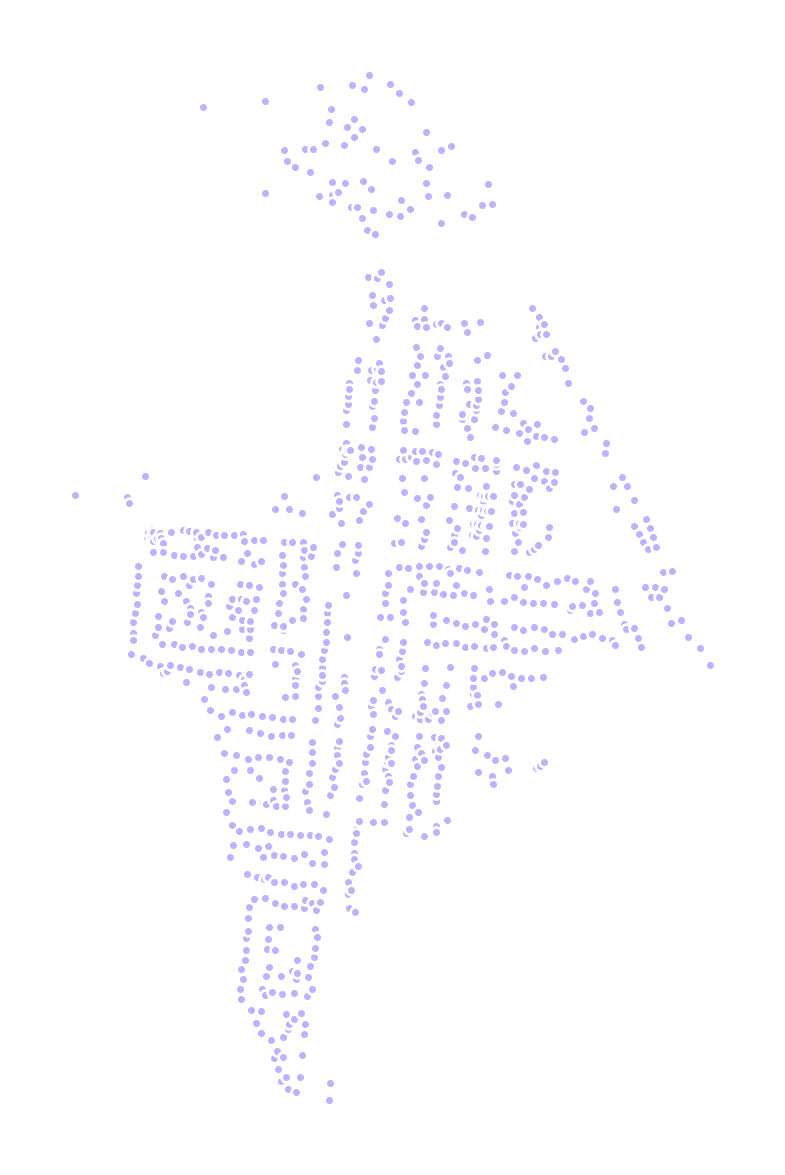

In [59]:
(fig, ax) = (
    plt.figure(figsize=(15, 15)),
    plt.axes(projection=ccrs.PlateCarree())
)
lnd.plotSites(fig, ax, size=50)
srv.plotClean(fig, ax, bbox=lnd.landLimits)

## Optimization

### Discrete

In [72]:
(GENS, GA_SUMSTAT, VERBOSE) = (500, np.mean, True)
# Parameters for the genetic algorithm internal operation ---------------------
POP_SIZE = int(10*(lnd.trapsNumber*1.25))
(MAT, MUT, SEL) = (
    {'cxpb': .3, 'indpb': 0.5}, 
    {'mutpb': .4, 'indpb': 0.5},
    {'tSize': 4}
)

In [73]:
(lnd, logbook) = srv.optimizeDiscreteTrapsGA(
    lnd, verbose=VERBOSE, generations=GENS, pop_size=POP_SIZE,
    mating_params=MAT, mutation_params=MUT, selection_params=SEL,
    fitFuns={'inner': np.sum, 'outer': GA_SUMSTAT}
)
srv.exportLog(logbook, OUT_PTH, '{}D-{:02d}-{:02d}_LOG'.format(ID, TRPS_NUM, RID))
srv.dumpLandscape(lnd, OUT_PTH, '{}D-{:02d}-{:02d}_TRP'.format(ID, TRPS_NUM, RID), fExt='pkl')

gen	nevals	min    	avg    	max    	std    	best	traps                   
0  	62    	240.854	467.449	1085.81	139.965	6   	[747, 254, 312, 698, 51]
1  	32    	240.854	379.132	707.223	101.537	5   	[747, 254, 312, 698, 51]
2  	35    	227.867	330.637	707.174	94.5268	2   	[747, 254, 312, 698, 64]
3  	34    	227.867	303.988	559.603	78.3614	8   	[747, 254, 312, 698, 64]
4  	33    	207.434	274.234	602.588	70.4081	0   	[747, 108, 312, 698, 51]
5  	39    	207.434	280.168	565.583	90.9639	25  	[747, 108, 312, 698, 51]
6  	40    	207.434	279.002	487.722	80.9304	15  	[747, 108, 312, 698, 51]
7  	36    	200.817	273.857	623.462	96.9965	27  	[747, 108, 312, 698, 64]
8  	38    	194.954	262.336	638.47 	86.9105	29  	[747, 108, 495, 698, 64]
9  	30    	194.954	253.02 	640.238	85.1302	2   	[747, 108, 495, 698, 64]
10 	33    	194.954	242.19 	673.962	89.3138	9   	[747, 108, 495, 698, 64]
11 	32    	194.954	229.918	513.124	64.9387	0   	[747, 108, 495, 698, 64]
12 	36    	194.954	241.185	498.283	79.0063	0   	[74

### Continuous

In [66]:
(GENS, GA_SUMSTAT, VERBOSE) = (500, np.mean, True)
# Parameters for the genetic algorithm internal operation ---------------------
POP_SIZE = int(10*(lnd.trapsNumber*1.25))
(MAT, MUT, SEL) = (
    {'cxpb': 0.5, 'alpha': 0.5}, 
    {'mean': 0, 'sd': 0.0025, 'mutpb': .4, 'ipb': .5},
    {'tSize': 3}
)
# Bounding box for traps position sampling ------------------------------------
delta=0.000015
dPad = (
    (bbox[0][0]*(1+delta), bbox[0][1]*(1-delta)), 
    (bbox[1][0]*(1-delta*20), bbox[1][1]*(1+delta*20))
)

In [63]:
(lnd, logbook) = srv.optimizeTrapsGA(
    lnd, verbose=VERBOSE,
    bbox=dPad, pop_size=POP_SIZE, generations=GENS,
    mating_params=MAT, mutation_params=MUT, selection_params=SEL,
    fitFuns={'inner': np.sum, 'outer': GA_SUMSTAT}
)
srv.exportLog(logbook, OUT_PTH, '{}D-{:02d}-{:02d}_LOG'.format(ID, TRPS_NUM, RID))
srv.dumpLandscape(lnd, OUT_PTH, '{}D-{:02d}-{:02d}_TRP'.format(ID, TRPS_NUM, RID), fExt='pkl')

gen	nevals	min    	avg    	max    	std    	best	traps                                                                                                                                                                                                   
0  	62    	350.973	841.501	3656.69	472.819	40  	[145.72217626965997, -16.81190314066287, 145.72146357168944, -16.813875588104068, 145.7242725406138, -16.81161191383889, 145.7245783163951, -16.809013047000633, 145.72298157043787, -16.80971213946355]
1  	44    	386.035	812.103	4026.85	542.212	24  	[145.71891637033892, -16.807777232511153, 145.72523302689183, -16.811530842371194, 145.72301969629768, -16.809739630817944, 145.7234954327711, -16.81436937459118, 145.71799065061975, -16.81042181382997]
2  	42    	386.035	980.64 	8419.74	1223.36	9   	[145.71891637033892, -16.807777232511153, 145.72523302689183, -16.811530842371194, 145.72301969629768, -16.809739630817944, 145.7234954327711, -16.81436937459118, 145.71799065061975, -16.81042181382997]


## Analysis

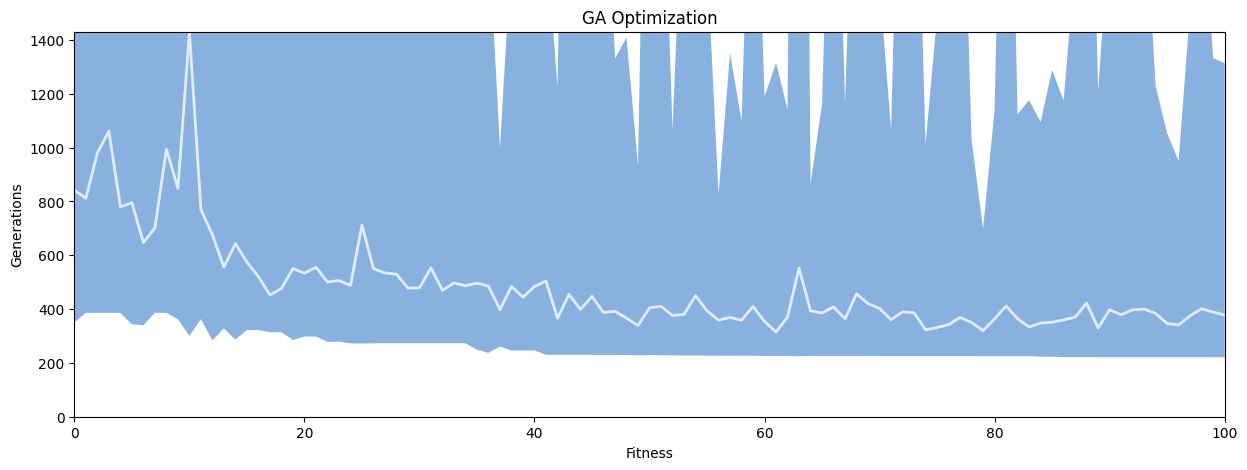

In [71]:
log = pd.DataFrame(logbook)
log.rename(columns={'median': 'avg'}, inplace=True)
(fig, ax) = plt.subplots(1, 1, figsize=(15, 5), sharey=False)
ax.set_title("GA Optimization")
ax.set_xlabel("Fitness")
ax.set_ylabel("Generations")
srv.plotGAEvolution(
    fig, ax, log,
    colors={'mean': '#ffffff', 'envelope': '#1565c0'},
    alphas={'mean': .75, 'envelope': 0.5},
    aspect=10
)
ax.set_ylim(0, max(log['avg']))
fig.savefig(
    path.join(OUT_PTH, '{}D-{:02d}-{:02d}_GA.png'.format(ID, TRPS_NUM, RID)),  
    facecolor='w', bbox_inches='tight', pad_inches=0.1, dpi=300
)

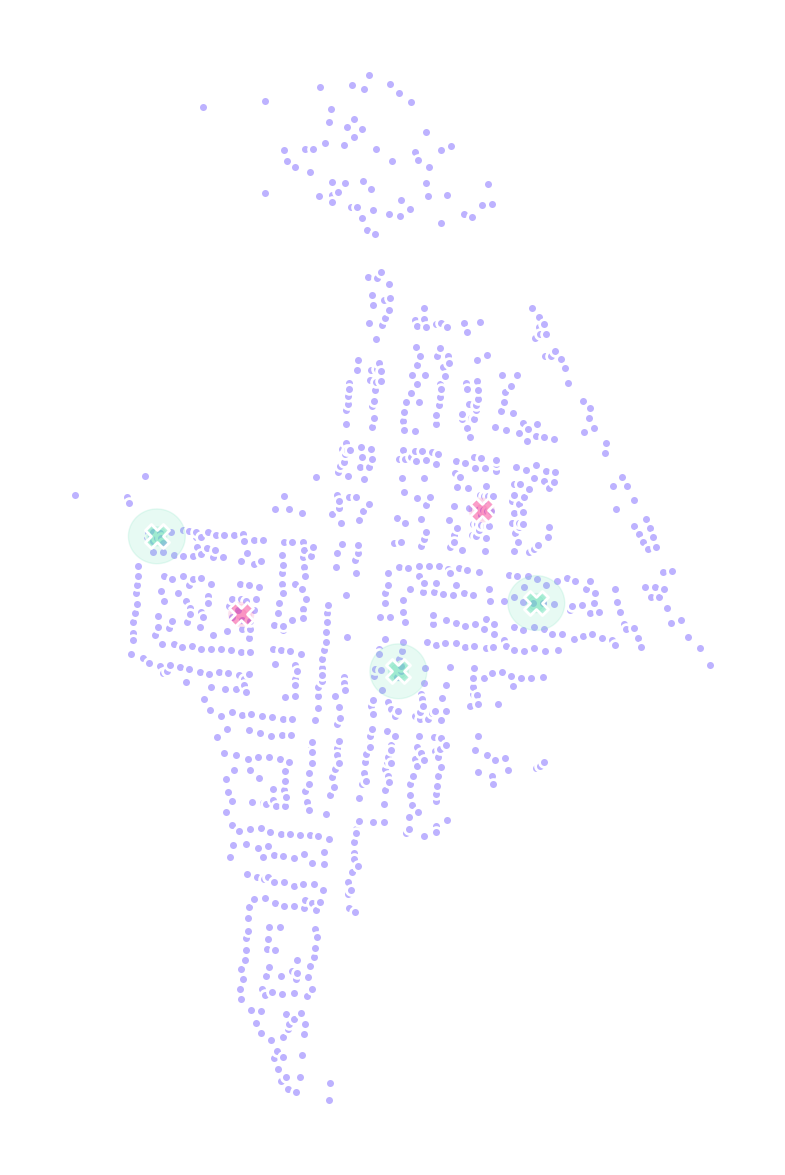

In [65]:
lnd = srv.loadLandscape(
    OUT_PTH, '{}D-{:02d}-{:02d}_TRP'.format(ID, TRPS_NUM, RID), 
    fExt='pkl'
)
(fig, ax) = (
    plt.figure(figsize=(15, 15)),
    plt.axes(projection=ccrs.PlateCarree())
)
lnd.updateTrapsRadii([0.250, 0.125, 0.100])
lnd.plotSites(fig, ax, size=50)
lnd.plotTraps(
    fig, ax, 
    zorders=(30, 25), transparencyHex='55', 
    proj=ccrs.PlateCarree()
)
srv.plotClean(fig, ax, bbox=lnd.landLimits)
fig.savefig(
    path.join(OUT_PTH, '{}D-{:02d}-{:02d}_TRP.png'.format(ID, TRPS_NUM, RID)), 
    facecolor='w', bbox_inches='tight', pad_inches=0.1, dpi=400
)